<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/richtracks2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

<div class="alert alert-block alert-info">
<h4>Имеется 3 датасета:</h4>
<p>1) Данные треков - Richtracks (описание приложено)</p>
<p>2) Данные точек этих треков - IncomingTrackPoints (описание также приложено)</p>
<p>3) Наборы токен-платформа (iOS или Android)</p>
</div>

<div class="alert alert-block alert-info">
<h4>Задание:</h4> 
<p>1) Переведите все параметры в одинаковую размерность</p>
<p>2) В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.</p>
</div>

In [0]:
# Pandas and numpy for data manipulation 
import pandas as pd
from pandas.api.types import infer_dtype
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 
  
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 100 columns of a dataframe
pd.set_option('display.max_columns', 100)


# Uploading files

In [0]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rich_tracks_2.csv', encoding='utf-8') 
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/inc_points_2.csv', encoding='utf-8') 
os = pd.read_csv('/content/drive/My Drive/Colab Notebooks/os.csv', encoding='utf-8') 

In [3]:
df1.head()

,Id,TrackToken,DeviceToken,IncomingTrackId,StartDate,EndDate,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,TrackOrigin,OriginChanged,AddressStart,AddressFinish,DistanceGPS,Urban,Region,Country,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,OriginalTrackOrigin,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,Prediction,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CityStart,CityFinish,UpdateDT,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters
0,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.50,5.000000,5.0,0.650,0.818,0.812,NaN,1061,0.000000,0.0,10.516666,3.75,0.20,0.800,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443
1,5148032,4BDD2EE6-FF53-4762-83DA-35A849935A99,669AFC5F-921C-40B9-B090-587BC95D34C2,20691750,2019-10-17 17:35:30.0000000 +05:00,2019-10-17 18:00:56.0000000 +05:00,414.076500,25.433333,0,1,4.75,0.000000,OriginalDriver,False,"улица Труда 166/1, Центральный район, Челябинс...","улица Блюхера 69А, Советский район, Челябинск,...",6.233,True,Челябинская область,Россия,5.0,5.00,4.993904,5.0,0.608,0.000,0.000,NaN,1061,1.033333,0.0,24.400000,3.75,1.00,1.000,1.0,0.875,70.917030,27.351787,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,100.0,75.0,92.500000,0.0,Челябинск,Челябинск,2019-10-17 13:06:47.537,0.0,0.0,16.0,0.0,29.0,0.0,NaN,NaN,NaN,0.0,17.956039
2,5147957,A0624E01-25FD-4B2D-A56E-617BB2546526,55D0C3A4-9E5B-4B57-BC22-E986158707F8,20690445,2019-10-17 16:35:25.0000000 +04:00,2019-10-17 16:49:04.0000000 +04:00,6.498145,13.650000,0,0,5.00,1.366667,OriginalDriver,False,"улица Мира 64, Волжский, Волгоградская область...","улица Пушкина 17, Волжский, Волгоградская обла...",7.135,True,Волгоградская область,Россия,5.0,5.00,5.000000,5.0,1.990,0.164,0.000,NaN,1061,0.000000,0.0,13.650000,5.00,1.00,1.000,1.0,1.000,63.825897,38.091320,0.000000,0.819,0.000,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Волжский,Волжский,2019-10-17 12:58:55.733,0.0,0.0,4.0,1.0,63.0,4.0,NaN,NaN,NaN,0.0,18.219858
3,5147902,D233A0EB-2D09-47F3-B0EB-3D852434F982,8E58407D-8933-4AFB-B158-81FF4548AEC4,20689861,2019-10-17 19:35:07.0000000 +07:00,2019-10-17 19:40:59.0000000 +07:00,1.148526,5.866667,0,1,4.75,1.983333,OriginalDriver,False,"Рентгеновская улица 77, Заельцовский район, Но...","Уфимская улица 29, Заельцовский район, Новосиб...",1.056,True,Новосибирская область,Россия,5.0,5.00,3.000000,5.0,0.000,0.000,0.000,NaN,1061,5.866667,0.0,0.000000,3.75,1.00,1.000,1.0,0.875,54.683998,18.418604,0.000000,0.551,0.000,1.0,NaN,100.0,100.0,100.0,50.0,85.000008,0.0,Новосибирск,Новосибирск,2019-10-17 12:49:51.397,0.0,0.0,37.0,20.0,51.0,23.0,NaN,NaN,NaN,0.0,5.328696
4,5150087,0195F786-966E-49AF-9326-82697CCC9011,0CE60F80-6BA3-4706-916B-BA864A434F46,20713090,2019-10-17 15:35:03.0000000 +03:00,2019-10-17 16:09:45.0000000 +03:00,8.160865,34.700000,2,1,2.65,0.000000,OriginalDriver,False,"улица Некрасова 56, Центральный район, Санкт-П...","Кузнецовская улица 31 лит А, Московский район,...",7.983,True,Санкт-Петербург,Россия,2.3,2.52,5.000000,5.0,0.883,0.191,0.226,NaN,1061,0.000000,0.0,34.700001,3.83,0.46,0.805,1.0,0.885,74.087929,31.291415,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,10

In [4]:
df2.head()

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [5]:
os.head()

,DeviceToken,os_version
0,2A768BE9-24E4-4274-AE30-03D07EE1D5B8,Android
1,CA447E48-E1C4-4F06-BA03-35C029C7E0F8,Android
2,EB26DDE2-8C75-439B-8FDA-AE838E15E944,iOS
3,3135D84F-1A08-4CBF-9439-D6C1BA58F4AA,iOS
4,16B59F05-9FEC-40DA-A181-C42B1AA2B517,Android


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 64 columns):
Id                        4000 non-null int64
TrackToken                4000 non-null object
DeviceToken               4000 non-null object
IncomingTrackId           4000 non-null int64
StartDate                 4000 non-null object
EndDate                   4000 non-null object
Distance                  4000 non-null float64
Duration                  4000 non-null float64
AccelerationCount         4000 non-null int64
DecelerationCount         4000 non-null int64
Rating                    4000 non-null float64
PhoneUsage                4000 non-null float64
TrackOrigin               4000 non-null object
OriginChanged             4000 non-null bool
AddressStart              3999 non-null object
AddressFinish             3999 non-null object
DistanceGPS               4000 non-null float64
Urban                     4000 non-null bool
Region                    2824 non-null object
Cou

In [0]:
android = os[os["os_version"] == "Android"][['DeviceToken']]
ios = os[os["os_version"] == "iOS"][['DeviceToken']]

In [0]:
data = df1.copy()

In [9]:
data["os"] = np.nan
data.loc[np.in1d(data.DeviceToken, android.DeviceToken), "os"] = "Android"
data.loc[np.in1d(data.DeviceToken, ios.DeviceToken), "os"] = "iOS"
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 65 columns):
Id                        4000 non-null int64
TrackToken                4000 non-null object
DeviceToken               4000 non-null object
IncomingTrackId           4000 non-null int64
StartDate                 4000 non-null object
EndDate                   4000 non-null object
Distance                  4000 non-null float64
Duration                  4000 non-null float64
AccelerationCount         4000 non-null int64
DecelerationCount         4000 non-null int64
Rating                    4000 non-null float64
PhoneUsage                4000 non-null float64
TrackOrigin               4000 non-null object
OriginChanged             4000 non-null bool
AddressStart              3999 non-null object
AddressFinish             3999 non-null object
DistanceGPS               4000 non-null float64
Urban                     4000 non-null bool
Region                    2824 non-null object
Cou

In [0]:
data = data.merge(df2, how='inner')

In [11]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 76 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
BeaconId,3791240,100.0
Prediction,3791240,100.0
VehicleId,3791240,100.0
RatingCornering,3073692,81.1
OriginalTrackOrigin,2759677,72.8
Region,731466,19.3
KPhoneUsage,717548,18.9
KOverSpeed,717548,18.9
KAcceleration,717548,18.9
KTimeOfDay,717548,18.9


In [12]:
data.head()

,Id,TrackToken,DeviceToken,IncomingTrackId,StartDate,EndDate,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,TrackOrigin,OriginChanged,AddressStart,AddressFinish,DistanceGPS,Urban,Region,Country,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,OriginalTrackOrigin,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,Prediction,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CityStart,CityFinish,UpdateDT,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters,os,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.5,5.0,5.0,0.65,0.818,0.812,NaN,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443,iOS,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.5,5.0,5.0,0.65,0.818,0.812,NaN,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443,iOS,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.5,5.0,5.0,0.65,0.818,0.812,NaN,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443,iOS,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.5,5.0,5.0,0.65,0.818,0.812,NaN,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443,iOS,0.0,55.8

In [0]:
data['Urban']=data['Urban'].replace({True:1, False:0})
data['OriginChanged']=data['OriginChanged'].replace({True:1, False:0})
data['os']=data['os'].replace({'Android':1, 'iOS':0})

In [14]:
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
data = data.drop(columns = list(missing_columns))
data.info()

Your selected dataframe has 76 columns.
There are 18 columns that have missing values.
We will remove 5 columns.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791240 entries, 0 to 3791239
Data columns (total 71 columns):
Id                        int64
TrackToken                object
DeviceToken               object
IncomingTrackId           int64
StartDate                 object
EndDate                   object
Distance                  float64
Duration                  float64
AccelerationCount         int64
DecelerationCount         int64
Rating                    float64
PhoneUsage                float64
TrackOrigin               object
OriginChanged             int64
AddressStart              object
AddressFinish             object
DistanceGPS               float64
Urban                     int64
Region                    object
Country                   object
RatingOverSpeed           float64
RatingAcceleration        float64
RatingTimeOfDay           float64
RatingPhoneUs

In [15]:
numerics = ['int64','float64']
newdf = data.select_dtypes(include=numerics)
newdf.head()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,OriginChanged,DistanceGPS,Urban,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,DeviationRatio,DeviationMeters,os,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [16]:
newdf.nunique()

Id                           2587
IncomingTrackId              2587
Distance                     2578
Duration                     1728
AccelerationCount              22
DecelerationCount              27
Rating                        118
PhoneUsage                    380
OriginChanged                   2
DistanceGPS                  2403
Urban                           2
RatingOverSpeed               101
RatingAcceleration            199
RatingTimeOfDay               149
RatingPhoneUsage               58
OverSpeedMileage             1613
MidOverSpeedMileage           980
HighOverSpeedMileage          682
CompanyId                      10
RushHours                     603
NightHours                     86
DailyHours                   1414
RatingDeceleration            247
KOverSpeed                     58
KAcceleration                  66
KTimeOfDay                      2
KDeceleration                  75
MaxSpeed                     2459
AverageSpeed                 2578
PhoneUsageOver

# Once we have identified the features to remove, we have to `drop` them


In [0]:
newdf = data.drop(columns=['Shared'])

In [0]:
label_encoder = LabelEncoder()
cat_list = ['TrackOrigin']
labelenc = newdf[cat_list]

In [19]:
for column in labelenc:
     labelenc.replace({'OriginalDriver': 0, 'Taxi': 0,'Passanger': 1})
     newdf[column] = label_encoder.fit_transform(newdf[column])
label_encoder.classes_

array(['OriginalDriver', 'Passanger', 'Taxi'], dtype=object)

In [0]:
cats = ['object','bool']

In [22]:
ohe = newdf.select_dtypes(include = cats)
ohe.head()

,TrackToken,DeviceToken,StartDate,EndDate,AddressStart,AddressFinish,Region,Country,CityStart,CityFinish,UpdateDT,PointDate
0,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:23.0000000 +03:00
1,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:23.0000000 +03:00
2,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:34.0000000 +03:00
3,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:34.0000000 +03:00
4,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:34.0000000 +03:00


In [0]:
newdf = newdf.select_dtypes(include=numerics)

In [24]:
newdf = newdf.groupby('Id').median().reset_index()

y = newdf['TrackOrigin'].values
newdf = newdf.drop(columns=['TrackOrigin'])
y

array([1., 1., 1., ..., 1., 1., 1.])

In [25]:
newdf.head()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,OriginChanged,DistanceGPS,Urban,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,DeviationRatio,DeviationMeters,os,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5078359,19891937.0,330.561652,81.783333,0.0,0.0,2.0,0.333333,1.0,37.217,1.0,1.0,5.0,3.0,4.0,7.770,5.709,3.194,3129.0,81.783333,0.0,0.000000,5.00,NaN,NaN,NaN,NaN,93.615631,34.603700,0.0,0.046,0.0,NaN,0.0,100.0,100.0,25.0,17.500000,0.0,0.0,57.0,30.0,311.0,183.0,0.0,63.061865,1.0,11.291015,-37.818070,145.000435,41801.0,0.020626,0.202338,1.570817e+09,-0.229850,2.990449,9.178452
1,5078535,19892757.0,4.707325,24.383333,0.0,0.0,4.0,0.316667,1.0,4.285,1.0,5.0,5.0,3.0,4.0,0.333,0.000,0.000,3129.0,24.383333,0.0,0.000000,5.00,NaN,NaN,NaN,NaN,61.451141,27.206699,0.0,0.003,0.0,NaN,100.0,100.0,100.0,50.0,85.000008,0.0,0.0,13.0,11.0,339.0,51.0,0.0,93.016231,1.0,2.182516,-37.776056,144.886075,43299.0,0.000423,0.004146,1.570822e+09,-0.105202,1.970360,9.399040
2,5078643,19888387.0,1.032507,1.683333,0.0,0.0,5.0,0.000000,1.0,1.043,1.0,5.0,5.0,3.0,5.0,0.000,0.000,0.000,3129.0,1.683333,0.0,0.000000,5.00,NaN,NaN,NaN,NaN,56.129097,36.989858,0.0,0.000,0.0,NaN,100.0,100.0,100.0,50.0,85.000008,0.0,0.0,45.0,0.0,56.0,0.0,0.0,1.645726,0.0,0.580703,-33.730456,151.033453,156814.0,0.000000,0.000000,1.570786e+09,-0.594696,-0.103256,-0.198387
3,5078815,19889292.0,15.776025,18.183333,6.0,7.0,3.0,0.000000,1.0,15.628,1.0,4.0,1.0,5.0,5.0,5.789,0.371,0.030,3129.0,0.000000,0.0,18.183332,1.00,NaN,NaN,NaN,NaN,104.835564,60.314566,0.0,0.000,0.0,NaN,0.0,25.0,100.0,0.0,6.250000,0.0,0.0,5.0,9.0,8.0,16.0,0.0,4.992488,0.0,36.978529,-32.009208,115.919745,9607.0,0.000000,0.000000,1.570421e+09,0.076927,-0.980690,-0.151039
4,5078995,19890131.0,8.696825,24.050000,0.0,1.0,4.8,1.166667,1.0,8.750,1.0,5.0,5.0,5.0,5.0,1.022,0.481,0.000,1061.0,0.000000,0.0,24.049999,3.93,1.0,1.0,1.0,0.895,76.031998,32.862011,0.0,0.440,0.0,1.0,100.0,100.0,100.0,0.0,70.000000,0.0,0.0,23.0,66.0,31.0,73.0,0.0,7.291171,0.0,11.213999,45.088206,38.979896,34289.0,0.000000,0.000000,1.570784e+09,0.645012,-0.255341,-0.000282


In [26]:
missing_values_table(newdf)

Your selected dataframe has 57 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
KOverSpeed,546,21.1
KAcceleration,546,21.1
KTimeOfDay,546,21.1
KDeceleration,546,21.1
KPhoneUsage,546,21.1
DeviationRatio,7,0.3
DeviationMeters,7,0.3


# Let's normalize our dataset

In [0]:
newdf.KOverSpeed[newdf.KOverSpeed.isna()]=np.random.normal(loc=newdf.KOverSpeed.median(), scale=3, size=newdf.KOverSpeed[newdf.KOverSpeed.isna()].shape[0])

newdf.KAcceleration[newdf.KAcceleration.isna()]=np.random.normal(loc=newdf.KAcceleration.median(), scale=3, size=newdf.KAcceleration[newdf.KAcceleration.isna()].shape[0])

newdf.KTimeOfDay[newdf.KTimeOfDay.isna()]=np.random.normal(loc=newdf.KTimeOfDay.median(), scale=3, size=newdf.KTimeOfDay[newdf.KTimeOfDay.isna()].shape[0])

newdf.KDeceleration[newdf.KDeceleration.isna()]=np.random.normal(loc=newdf.KDeceleration.median(), scale=3, size=newdf.KDeceleration[newdf.KDeceleration.isna()].shape[0])

newdf.KPhoneUsage[newdf.KPhoneUsage.isna()]=np.random.normal(loc=newdf.KPhoneUsage.median(), scale=3, size=newdf.KPhoneUsage[newdf.KPhoneUsage.isna()].shape[0])

newdf.DeviationRatio[newdf.DeviationRatio.isna()]=np.random.normal(loc=newdf.DeviationRatio.median(), scale=3, size=newdf.DeviationRatio[newdf.DeviationRatio.isna()].shape[0])

newdf.DeviationMeters[newdf.DeviationMeters.isna()]=np.random.normal(loc=newdf.DeviationMeters.median(), scale=3, size=newdf.DeviationMeters[newdf.DeviationMeters.isna()].shape[0])


In [0]:
X_train, X_test, y_train, y_test = train_test_split(newdf, y, test_size=0.3, random_state=42, shuffle=True) 

In [0]:
scaler_std = StandardScaler()

X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)

# Feature scaling with MinMaxScaler 
scaler_mm = MinMaxScaler() 
X_train_scaled = scaler_mm.fit_transform(X_train_scaled)
X_test_scaled = scaler_mm.transform(X_test_scaled)

# Существует много сравнительных обзоров, которые помогут сориентироваться при выборе алгоритма, но я предпочитаю попробовать в работе несколько и посмотреть, какой лучше. Машинное обучение по большей части основывается на эмпирических, а не теоретических результатах, и практически невозможно заранее понять, какая модель окажется точнее.

In [30]:
model_dict = {
   'LR': LinearRegression(),
   'Lasso': Lasso(random_state=42),
   'Ridge': Ridge(random_state=42),
   'Enet': ElasticNet(random_state=42),
   'KNN': KNeighborsRegressor(),
   'DT': DecisionTreeRegressor(random_state=42),
   'RF': RandomForestRegressor(random_state=42),
   'GBR': GradientBoostingRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_test = model_dict[model].predict(X_test_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_test = r2_score(y_test, y_pred_test)
    score_list.append((score_train, score_test))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\t train: {np.round(scores[0], 4)} \n\t test: {np.round(scores[1], 4)}')

LR: 
	 train: 0.8988 
	 test: 0.9
Lasso: 
	 train: 0.0 
	 test: -0.0001
Ridge: 
	 train: 0.8978 
	 test: 0.9004
Enet: 
	 train: 0.0 
	 test: -0.0001
KNN: 
	 train: 0.9208 
	 test: 0.8795
DT: 
	 train: 1.0 
	 test: 0.8897
RF: 
	 train: 0.9898 
	 test: 0.9307
GBR: 
	 train: 0.9779 
	 test: 0.9317


# One of the best results with data preprocessing is RandomForest baseline R^2 = 0.9307


# We have to implement Principal Component Analysis (Метод главных компонент) in order to reduce the dimension of the dataset.

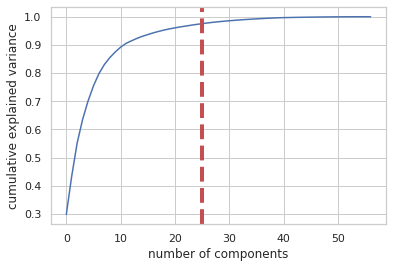

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.298594,0.298594
1,0.434602,0.136008
2,0.552274,0.117673
3,0.635356,0.083082
4,0.700792,0.065435


In [31]:
pca_test = PCA(n_components=57)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=25, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head())

# From now we will use only 25 main components. So, we have decreased the dataset dimension more than twice from 57 to 25.

In [0]:
pca = PCA(n_components=25)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [33]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=newdf.columns, index=pca_dims)
pca_test_df.head().T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4
Id,-0.003995,-0.013779,0.008750,-0.025110,-0.013697
IncomingTrackId,-0.000397,-0.009419,0.020059,-0.017287,-0.021431
Distance,0.002720,0.007381,-0.000899,-0.001618,0.004787
Duration,0.041911,-0.006750,-0.004480,-0.015299,0.003792
AccelerationCount,0.022754,-0.027734,0.006853,0.033748,0.016906
DecelerationCount,0.023202,-0.026766,0.002099,0.024812,0.017889
Rating,-0.201682,0.047678,0.052791,-0.351555,-0.062315
PhoneUsage,0.004381,-0.002706,0.002294,-0.000925,-0.000054
OriginChanged,0.220315,0.291511,0.458962,0.455529,-0.420799
DistanceGPS,0.069314,-0.006884,-0.001270,-0.034378,-0.014031


In [35]:
RF_pca = RandomForestRegressor()
RF_pca.fit(X_train_scaled_pca, y_train)
display(RF_pca.score(X_train_scaled_pca, y_train))

0.9754881213117936

# Here we can see that our model is very accurate because of the 97% score.

# But what if that is not the limit? 
# Let's try to configure hyperparameters of the model using RandomizedSearchCV

In [36]:
%%time

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(RF_pca, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)

print(rs.best_score_)
print(rs.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


0.8636959438420816
{'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}
CPU times: user 6.49 s, sys: 348 ms, total: 6.84 s
Wall time: 3min 9s


# Here we can see that there is no need for configuring hyperparameteres 

# Let's measure the quality of the model by samples with default hyperparameteres




In [37]:
y_pred_train = RF_pca.predict(X_train_scaled_pca)
y_pred_test = RF_pca.predict(X_test_scaled_pca)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_test, y_pred_test)

print(f' Train score: {np.round(score_train, 4)}\n Test score: {np.round(score_valid, 4)}')

 Train score: 0.9755
 Test score: 0.8482


<div class="alert alert-block alert-green">
<h2> Finally, we can see that our model predicts accurately.</h2>
</div>